# Quantum chemistry with VQE

This tutorial will show you how to solve an important problem for quantum chemistry using PennyLane on Amazon Braket: finding the ground-state energy of a molecule. The problem can be tackled using near-term quantum hardware by implementing the variational quantum eigensolver (VQE) algorithm. You can find further details on quantum chemistry and VQE in both the [Braket VQE](../hybrid_quantum_algorithms/VQE_Chemistry/VQE_chemistry_braket.ipynb) notebook and PennyLane [tutorials](https://pennylane.ai/qml/demos_basics.html).

## From quantum chemistry to quantum circuits

Our first step is to convert our chemistry problem into something that can be tackled with a quantum computer. To do this, we will use PennyLane's ``qchem`` package. If running on a local machine, the ``qchem`` package must be installed separately by following [these](https://pennylane.readthedocs.io/en/stable/introduction/chemistry.html) instructions.

In [1]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np

qml.enable_tape()  # Unlocks the latest features in PennyLane

The input chemistry data is often provided in the form of a geometry file containing details about the molecule. Here, we consider the hydrogen molecule $\mathrm{H}_2$ whose atomic structure is stored in the [h2.xyz](./qchem/h2.xyz) file. The qubit Hamiltonian for $\mathrm{H}_2$ is built using the ``qchem`` package.

In [2]:
h, qubits = qchem.molecular_hamiltonian(name="h2", geo_file="qchem/h2.xyz")
print(h)

(-0.042078976477823424) [I0]
+ (0.17771287465139962) [Z0]
+ (0.17771287465139957) [Z1]
+ (-0.24274280513140412) [Z2]
+ (-0.24274280513140417) [Z3]
+ (0.17059738328801044) [Z0 Z1]
+ (0.04475014401535161) [Y0 X1 X2 Y3]
+ (-0.04475014401535161) [Y0 Y1 X2 X3]
+ (-0.04475014401535161) [X0 X1 Y2 Y3]
+ (0.04475014401535161) [X0 Y1 Y2 X3]
+ (0.1229330505618379) [Z0 Z2]
+ (0.1676831945771895) [Z0 Z3]
+ (0.1676831945771895) [Z1 Z2]
+ (0.1229330505618379) [Z1 Z3]
+ (0.1762764080431958) [Z2 Z3]


In the VQE algorithm, we compute the energy of the $\mathrm{H}_2$ molecule by measuring the expectation value of the above Hamiltonian on a variational quantum circuit. Our objective is to train the parameters of the circuit so that the expectation value of the Hamiltonian is minimized, thereby finding the ground state energy of the molecule.

In this tutorial, we also want to compute the total spin. To that aim, we use the ``qchem`` package to build the total-spin operator $S^2$:

In [3]:
electrons = 2  # Molecular hydrogen has two electrons

S2 = qchem.spin2(electrons, qubits)
print(S2)

(0.75) [I0]
+ (0.375) [Z1]
+ (-0.375) [Z0 Z1]
+ (0.125) [Z0 Z2]
+ (0.375) [Z0]
+ (-0.125) [Z0 Z3]
+ (-0.125) [Z1 Z2]
+ (0.125) [Z1 Z3]
+ (0.375) [Z2]
+ (0.375) [Z3]
+ (-0.375) [Z2 Z3]
+ (0.125) [Y0 X1 Y2 X3]
+ (0.125) [Y0 Y1 X2 X3]
+ (0.125) [Y0 Y1 Y2 Y3]
+ (-0.125) [Y0 X1 X2 Y3]
+ (-0.125) [X0 Y1 Y2 X3]
+ (0.125) [X0 X1 X2 X3]
+ (0.125) [X0 X1 Y2 Y3]
+ (0.125) [X0 Y1 X2 Y3]


## Grouping observables to reduce circuit executions

Suppose we want to measure the expectation value of the electronic Hamiltonian ``h``. This Hamiltonian is composed of 15 individual observables that are tensor products of Pauli operators:

In [4]:
print("Number of Pauli terms in h:", len(h.ops))

Number of Pauli terms in h: 15


A straightforward approach to measuring the expectation value would be to implement the circuit 15 times, and each time measuring one of the Pauli terms that form part of the Hamiltonian ``h``. However, we could be more efficient. The Pauli terms can be separated into groups (see PennyLane's [grouping](https://pennylane.readthedocs.io/en/stable/code/qml_grouping.html) module) that can be measured concurrently on a single circuit. Elements of each group are known as qubit-wise commuting observables. The Hamiltonian ``h`` can be split into 5 groups:

In [5]:
groups, coeffs = qml.grouping.group_observables(h.ops, h.coeffs)
print("Number of qubit-wise commuting groups:", len(groups))

Number of qubit-wise commuting groups: 5


Practically, this means that instead of executing 15 separate circuits, we just need to execute 5. This saving can become even more pronounced as the number of Pauli terms in the Hamiltonian increases. For example, switching to a larger molecule or a different chemical basis set can increase both the number of qubits and the number of terms.

Fortunately, the PennyLane/Braket pipeline has builtin support for pre-grouping the observables in a Hamiltonian to minimize the number of device executions, saving both runtime and simulation fees when using remote devices. Optimized observable grouping will be used in the rest of this tutorial.

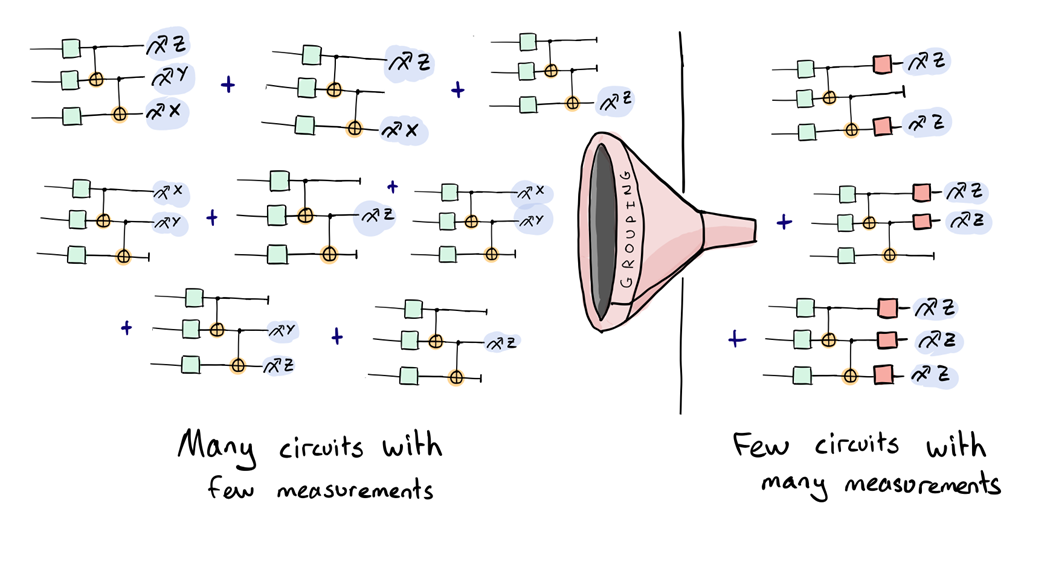

## Defining an ansatz circuit

We now set up the ansatz circuit that will be trained to prepare the ground state of the Hamiltonian. Our first step is to load the local Braket device:

In [6]:
dev = qml.device("braket.local.qubit", wires=qubits)

This tutorial uses a chemically-inspired circuit called the Unitary Coupled-Cluster Singles and Doubles ([UCCSD](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.templates.subroutines.UCCSD.html)) ansatz. To use this, we must define some additional inputs from quantum chemistry.

In [7]:
ref_state = qchem.hf_state(electrons, qubits)  # Hartree-Fock state
excitations = qchem.excitations(electrons, qubits)  # generate single- and double-excitations
s_wires, d_wires = qchem.excitations_to_wires(*excitations)  # map excitations to the wires that the UCCSD circuit will act on

<div class="alert alert-block alert-info">
<b>Note</b> A variety of alternative ansätze and templates are <a href="https://pennylane.readthedocs.io/en/latest/code/qml_templates.html#module-pennylane.templates.layers">available</a> and different choices will result in varying circuit depth and number of trainable parameters.
</div>

Our ansatz circuit is then simple to define:

In [8]:
def circuit(params, wires):
    qml.templates.UCCSD(params, init_state=ref_state, s_wires=s_wires, d_wires=d_wires, wires=wires)

Note that an output measurement has not yet been defined! This is the next step.

## Measuring the energy and total spin

We discussed earlier that we want to minimize the expectation value of the qubit Hamiltonian, corresponding to the energy of $\mathrm{H}_2$. The expectation values of this Hamiltonian and the total spin $\hat{S}^2$ operator can be defined using:

In [9]:
energy_expval = qml.ExpvalCost(circuit, h, dev, optimize=True)
S2_expval = qml.ExpvalCost(circuit, S2, dev, optimize=True)

Notice the ``optimize=True`` option. This instructs PennyLane and Braket to break up each Hamiltonian into qubit-wise commuting groups for increased device-execution efficiency.

Let's now initialize some random values and evaluate the energy and spin. The total spin $S$ of the prepared state can be obtained from the expectation value $\langle \hat{S}^2 \rangle$ using $S=-\frac{1}{2} + \sqrt{\frac{1}{4} + \langle \hat{S}^2 \rangle}$. We can define a function to compute $S$:

In [10]:
def spin(params):
    return -0.5 + np.sqrt(1 / 4 + S2_expval(params))

In [11]:
np.random.seed(1967)
params = np.random.normal(0, np.pi, len(s_wires) + len(d_wires))

The energy and total spin are then

In [12]:
print("Energy:", energy_expval(params))
print("Spin:  ", spin(params))

Energy: -0.5728383913503483
Spin:   0.8358744751644029


Since we have picked random parameters, the measured energy does not correspond to the ground state energy and the prepared state is not an eigenstate of the total-spin operator. We must now train the parameters to find the minimum energy.

## Minimizing the energy

The energy can be minimized by choosing an optimizer and running the standard optimization loop:

In [13]:
opt = qml.GradientDescentOptimizer(stepsize=0.4)

In [14]:
iterations = 40

energies = []
spins = []

for i in range(iterations):
    params = opt.step(energy_expval, params)
    
    e = energy_expval(params)
    s = spin(params)
    
    energies.append(e)
    spins.append(s)
    
    if (i + 1) % 5 == 0:
        print(f"Completed iteration {i + 1}")
        print("Energy:", e)
        print("Total spin:", s)
        print("----------------")
        
print(f"Optimized energy: {e} Ha")
print(f"Corresponding total spin: {s}")

Completed iteration 5
Energy: -0.8431944276242789
Total spin: 0.5516429655083164
----------------
Completed iteration 10
Energy: -1.0363737583927664
Total spin: 0.2384937727695714
----------------
Completed iteration 15
Energy: -1.1051703984929993
Total spin: 0.08609968513511335
----------------
Completed iteration 20
Energy: -1.1260757917995217
Total spin: 0.02977443469137786
----------------
Completed iteration 25
Energy: -1.1328388288060651
Total spin: 0.0100760244293715
----------------
Completed iteration 30
Energy: -1.135075420261958
Total spin: 0.00337487557590066
----------------
Completed iteration 35
Energy: -1.1358187273449236
Total spin: 0.0011258798543014592
----------------
Completed iteration 40
Energy: -1.1360660538819118
Total spin: 0.00037507164606986887
----------------
Optimized energy: -1.1360660538819118 Ha
Corresponding total spin: 0.00037507164606986887


The exact value for the ground state energy of molecular hydrogen has been theoretically calculated as ``-1.136189454088`` Hartrees (Ha). Notice that the optimized energy is off by less than a thousandth of a Hartree. Furthermore, the optimized state is an eigenstate of the total-spin operator with eigenvalue $S=0$ as expected for the ground state of the $\mathrm{H}_2$ molecule. Hence, our above results look very promising! We would get even closer to the theory values if we increase the number of iterations.

Let's visualize how the two quantities evolved during optimization:

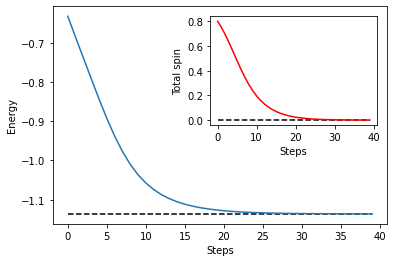

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

theory_energy = -1.136189454088
theory_spin = 0

plt.hlines(theory_energy, 0, 39, linestyles="dashed", colors="black")
plt.plot(energies)
plt.xlabel("Steps")
plt.ylabel("Energy")

axs = plt.gca()

inset = inset_axes(axs, width="50%", height="50%", borderpad=1)
inset.hlines(theory_spin, 0, 39, linestyles="dashed", colors="black")
inset.plot(spins, "r")
inset.set_xlabel("Steps")
inset.set_ylabel("Total spin");

We have learned how to efficiently find the ground state energy of a molecule using the PennyLane/Braket pipeline!

<div class="alert alert-block alert-info">
<b>What's next?</b> The <code>qchem</code> folder contains additional molecular structure files for different atomic separations of molecular hydrogen. Pick one of the separations and find the ground state energy. How does the ground state energy change with atomic separation? 
</div>